<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Код-для-запуска-модели" data-toc-modified-id="Код-для-запуска-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Код для запуска модели</a></span></li><li><span><a href="#Результаты-работы-модели" data-toc-modified-id="Результаты-работы-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Результаты работы модели</a></span></li></ul></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

## Описание проекта

**Заказчик**

Сетевой супермаркет «Хлеб-Соль»

**Задача**

Постройте модель, которая по фотографии определит приблизительный возраст человека.

**Данные**

Набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# Загружаем бибилотеки. 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [2]:
# Загружаем датасет
path = '/datasets/faces/'
labels = pd.read_csv(path +'labels.csv')
datagen = ImageDataGenerator(rescale=1./255)

# Создаем загрузчик данных.
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
# 10 строк датасета.
labels.sample(10)

,file_name,real_age
7259,007277.jpg,40
6093,006096.jpg,42
7569,007591.jpg,27
3696,003696.jpg,40
2305,002305.jpg,8
4021,004021.jpg,32
3486,003486.jpg,30
774,000774.jpg,26
5930,005931.jpg,28
2641,002641.jpg,31


In [4]:
# Пропуски и типы данных.
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# Размер датасета.
len(labels)

7591

In [6]:
# Метрики возраста.
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

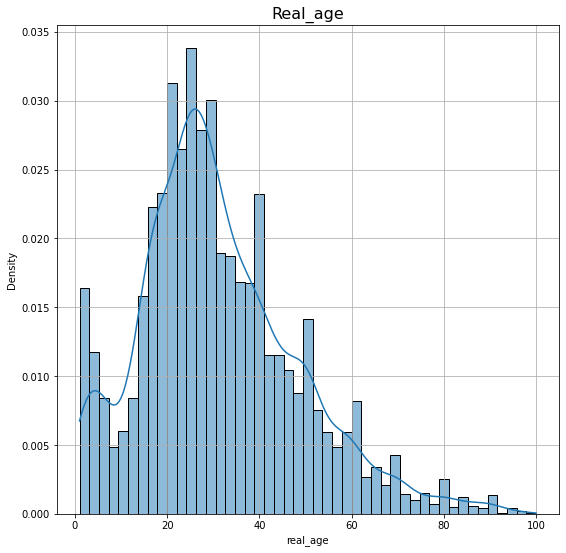

In [7]:
# Постороим гистограмму плотности для возраста.
plt.subplots(figsize=(9, 9))
plt.title('Real_age', fontsize=16)
sns.histplot(      # гистограммы плотности
        labels['real_age'], 
        kde=True,
        stat="density", 
        linewidth=1)
plt.grid(True)
plt.show()

In [8]:
# Выгрузим первый батч.
features, target = next(gen_flow)

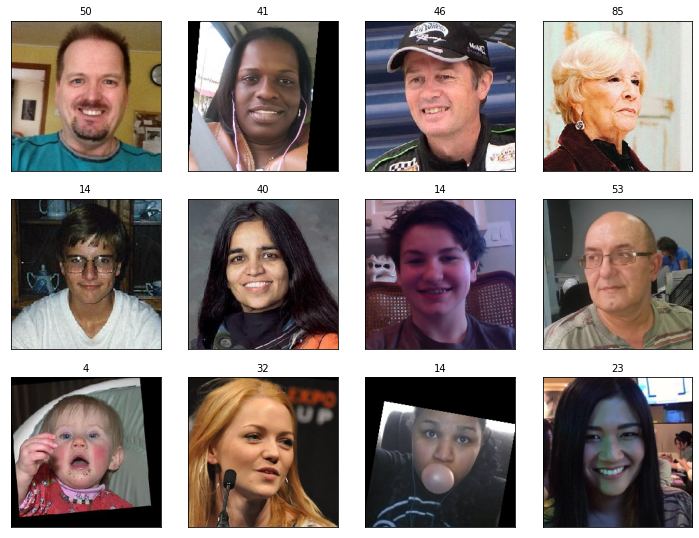

In [9]:
# Вывод первых 10 фото. 
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.title(target[i], fontsize=10)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- Медиана и среднее не сильно отличаться, но правый хвост присутствует;
- В Диапазоне от 20 до 40 лет 50% всех фотографий и это может быть проблемой для исследования, модель научится хорошо определять этот возраст, а задача научится отделять тех кто старше и 18 и младше, а вот в области 14-18 лет наблюдается сильное уменьшение данных;
- С совсем маленькими покупателями (младше 10) наверно проблем не будет;
- На фотографиях есть представители обоих полов и разных национальностей и рас;
- Фотографий 7591 что достаточно дл посторения ResNet50 без заморозок;
- Это портреты, не все они строго анфас, есть полу оборот как право так и влево. Может помочь горизонтальное отображение;
- На многих изображениях ест улыбка;
- Есть изображения с повернутыми границами можно по посмотреть небольшой поворот угла;
- Лица довольно крупные и занимают от 30 до 60 площади, приближать особо нет смыла.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

### Код для запуска модели

```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path +'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True
                                      )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

### Результаты работы модели

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 52s - loss: 198.1559 - mae: 10.0900 - val_loss: 546.1340 - val_mae: 18.3330
Epoch 2/10
178/178 - 44s - loss: 79.8655 - mae: 6.8275 - val_loss: 474.6526 - val_mae: 16.6326
Epoch 3/10
178/178 - 44s - loss: 56.7696 - mae: 5.7227 - val_loss: 298.8435 - val_mae: 12.7191
Epoch 4/10
178/178 - 44s - loss: 43.7572 - mae: 5.0124 - val_loss: 214.7040 - val_mae: 11.3972
Epoch 5/10
178/178 - 44s - loss: 34.9209 - mae: 4.5284 - val_loss: 79.7480 - val_mae: 6.6903
Epoch 6/10
178/178 - 43s - loss: 24.8773 - mae: 3.8206 - val_loss: 83.3060 - val_mae: 6.9676
Epoch 7/10
178/178 - 44s - loss: 21.7517 - mae: 3.5634 - val_loss: 80.8970 - val_mae: 6.8039
Epoch 8/10
178/178 - 44s - loss: 18.9940 - mae: 3.3268 - val_loss: 77.8185 - val_mae: 6.3902
Epoch 9/10
178/178 - 44s - loss: 15.9664 - mae: 3.0237 - val_loss: 99.5506 - val_mae: 7.5047
Epoch 10/10
178/178 - 44s - loss: 12.2023 - mae: 2.6748 - val_loss: 62.7933 - val_mae: 5.8040

60/60 - 11s - loss: 62.7933 - mae: 5.8040
Test MAE: 5.8040
```

## Анализ обученной модели

- Модель удовлетворила результату, 5.80 на последней 10 эпохе;
- Переворот по горизонтали улучшил результат и не снизил время обучения, но было увеличено количество эпох. 
- Модель довольно быстро обучилась на эпоху от 40-60 секунд, если loss сделать MAE то обучение на 2-3 секунды дольше. 